## Tianyu(William) Zhang, UID: N19645827, NetID: tz1280

### Nonlinear Problems in Finance (MATH-GA.2045-001), New York University, Fall 2019
# Homework I

### Due Date: 11:55 PM Tuesday, Oct 1 2019


You should turn in the notebook at NYU Classes website.

Please comment your code properly.

Before you turn in the notebook, press the "Run all cells" button in the toolbar, and make sure all the calculation results and graphs are produced correctly in a reasonable time frame, and then save the notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import laguerre
from scipy.interpolate import interp1d
plt.rc('figure', figsize=(6, 5.5))
plt.rc('axes', grid=True, xmargin=0, ymargin=0, autolimit_mode='round_numbers')

# 1. Conditional Expection and Least Square Regression

Let $X$ and $Y$ be two random variables. The conditional expectation $\mathbb{E}\left[Y|X\right]$ is a function $f^{\ast}$ of $X$ that best approximates $Y$ in the least square sense, i.e.,

$$\mathbb{E}\left[Y|X\right]=f^{\ast}(X)\quad\text{and}\quad\mathbb{E}\left[\left|Y-f^{\ast}(X)\right|^2\right]\leq\mathbb{E}\left[\left|Y-f(X)\right|^2\right]\text{ for any function }f\text{ of }X$$

Let us define the random variables $X$ and $Y$ by
$$
g(x) = x \frac{1 + x}{1 + x^2}, \qquad X \sim \mathcal{N}(0, 1), \quad Y = g(X) + \varepsilon
$$
where $\varepsilon \sim \mathcal{N}(0, 1/16)$ is independent of $X$.

Note that $\mathbb{E}\left[\left.Y\right|X\right] = \mathbb{E}\left[\left.g(X)+\varepsilon\right|X\right] = g(X)+\mathbb{E}\left[\left.\varepsilon\right|X\right] = g(X)$.

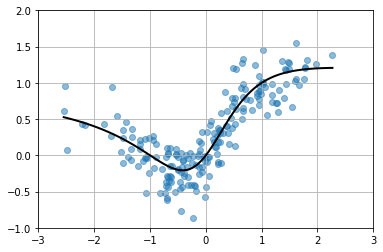

In [2]:
# Plot a random sample of the joint distribution and the 
# theoretical conditional expectation of Y wrt X.

def g(x):
    return x*(1+x)/(1+x**2)

n = 200
sigma = 0.25
X = np.random.randn(n)
Y = g(X) + sigma * np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
x = np.linspace(X.min(), X.max(), 101)
ax.plot(x, g(x), 'k', linewidth=2)

## Parametric regression

The conditional expection $\mathbb{E}\left[\left.Y\right|X\right]$ is approximated by a linear combination of a set of given <em>basis</em> functions $\{f_i(X)\}_{0\leq i\leq n}$, i.e.,

$$\mathbb{E}\left[Y|X\right]\approx \beta_0^*f_0(X)+\cdots+\beta_n^*f_n(X)$$

where 

$$\mathbb{E}\left[\left(Y-\beta_0^*f_0(X)-\cdots-\beta_n^*f_n(X)\right)^2\right] = \min_{\beta_1,\ldots,\beta_n}\mathbb{E}\left[\left(Y-\beta_0f_0(X)-\cdots-\beta_nf_n(X)\right)^2\right]$$

Given $N$ observations $\left((x_1,y_1),\ldots,(x_N, y_N)\right)$ of $X$ and $Y$, one finds the optimal parameters $\beta_i$ by solving the least square problem $\min_\beta\|A\beta-y\|_2$, where
$$A=\begin{bmatrix}f_0(x_1) & \cdots & f_n(x_1)\\ \vdots & \ddots & \vdots \\ f_0(x_N) & \cdots & f_n(x_N)\end{bmatrix}\quad
\text{and}\quad y=\begin{bmatrix}y_1\\ \vdots \\ y_N\end{bmatrix}$$

The numpy routine <strong>numpy.linalg.lstsq</strong> can be used to solve such linear least square problems.

### Polynomials

The basis functions are taken to be power functions $f_i(X)=X^{i}$, that is $\mathbb{E}\left[Y|X\right]$ is a polynomial of $X$. The numpy routine <strong>numpy.polyfit</strong> is a convenient way to obtain the least square polynomial fit.

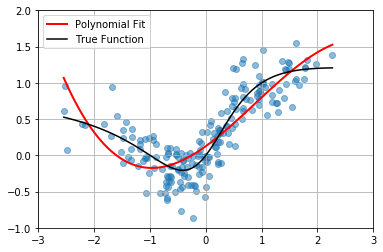

In [3]:
# Fit a polynomial of degree 3 to the sample points (X, Y)
p = np.polyfit(X, Y, deg=3)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p, x), 'r', lw=2, label='Polynomial Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)

### Piecewise Linear Regression

In [4]:
def pwlinear_basis(xknots):
    """Basis that represent a piecewise linear function with given knots"""
    fs = [lambda x: np.ones_like(x, dtype=np.float), lambda x: x-xknots[0]]
    fs.extend([lambda x, a=xknots[i]: np.maximum(x-a, 0) for i in range(len(xknots))])
    return fs

def pwlinear_fit(xdata, ydata, xknots):
    """Fit a piecewise linear function with xknots to xdata and ydata"""
    fs = pwlinear_basis(xknots)
    A = np.vstack([f(xdata) for f in fs]).T
    ps = np.linalg.lstsq(A, ydata, rcond=None)[0]
    return ps, fs

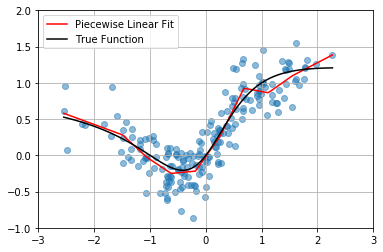

In [5]:
xknots = np.linspace(np.percentile(X, 5), np.percentile(X, 95), 8)
# fs = pwlinear_basis(xknots)
ps, fs = pwlinear_fit(X, Y, xknots)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
# xx = np.linspace(x[0]-1, x[-1]+1, 200)
ax.plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), 'r', label='Piecewise Linear Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)

## Nonparametric regression

### Nadaraya-Watson Kernel regression (Local Weighted Average)

Here, no parametric form is assumed for $\mathbb{E}[Y|X]$. Instead, local averages of $Y$ values are computed, given the value of $X$:

$$\mathbb{E}\left[Y|X\right]\approx\frac{\sum_{i=1}^NK_h(x-x_i)y_i}{\sum_{i=1}^NK_h(x-x_i)}$$
where $K$ is a kernel function and $K_h(x)=K(x/h)$, $h$ is the <em>bandwidth</em>. $K_h$ approximates the Dirac mass at zero.

### Local Linear Regression

The locally weighted linear regression solves a separate weighted least squares problem at each target point $x$,

$$\hat{\alpha},\hat{\beta} = \text{argmin}_{\alpha,\beta}\sum_{i=1}^NK_h(x-x_i)\left[y_i-\alpha-\beta x_i\right]^2$$

which yields an estimate $\hat{\alpha}+\hat{\beta}x$. Note that $\hat{\alpha}$ and $\hat{\beta}$ depend on $x$. The locally-weighted averages can be badly biased on the boundaries. This bias
can be removed by local linear regression to the first order.

<b>Note.</b> To speed up, we often perform the local regression only at a selection of points and then use interpolation/extrapolation to evaluate at other target points.

In [6]:
# Non-parametric regression function

def gauss_kern(x):
    """Gaussian kernel function"""
    return np.exp(-x**2/2)

def kern_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


def ll_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Local Linear Regression

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    
    def func(xx):
        weights = np.sqrt(kern((xdata-xx)/bandwidth))
        b = ydata*weights
        A = np.vstack((np.ones_like(xdata), xdata-xx)).T*weights[:, np.newaxis]
        yy, _ = np.linalg.lstsq(A, b, rcond=None)[0]
        return yy
    
    return np.vectorize(func)(x)

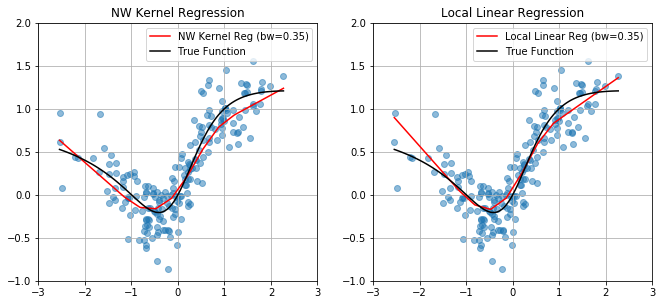

In [7]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
# NW Kernel Regression
xknots0 = np.linspace(np.percentile(X, 5), np.percentile(X, 95), 10)
yknots0 = kern_reg(xknots0, X, Y, bw_silverman, gauss_kern)
f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
axs[0].plot(x, f0(x), color='r', label='NW Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[0].set_title('NW Kernel Regression')
# Local Linear Regression
xknots1 = xknots0
yknots1 = ll_reg(xknots1, X, Y, bw_silverman, gauss_kern)
f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
axs[1].plot(x, f1(x), color='r', label='Local Linear Reg (bw={:.2f})'.format(bw_silverman))
axs[1].set_title('Local Linear Regression')
for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    ax.legend(loc=0)

## Questions

<b>Question 1.1</b>. (Parametric regression) In general, increasing the number of basis functions in the regression gives us more flexibility to better fit the data. However, having too many parameters in the model oftentimes leads to overfitting, which usually has poor predictive performance and is over-sensitive to small noise in the data. To observe the overftting phenomenon, in polynomial fit, try to use different degrees of the polynomials; in piecewise-linear regression, try to use difference number of knots. Then reproduce the scatter plot with fitted regression function. Compare and comment on the results.

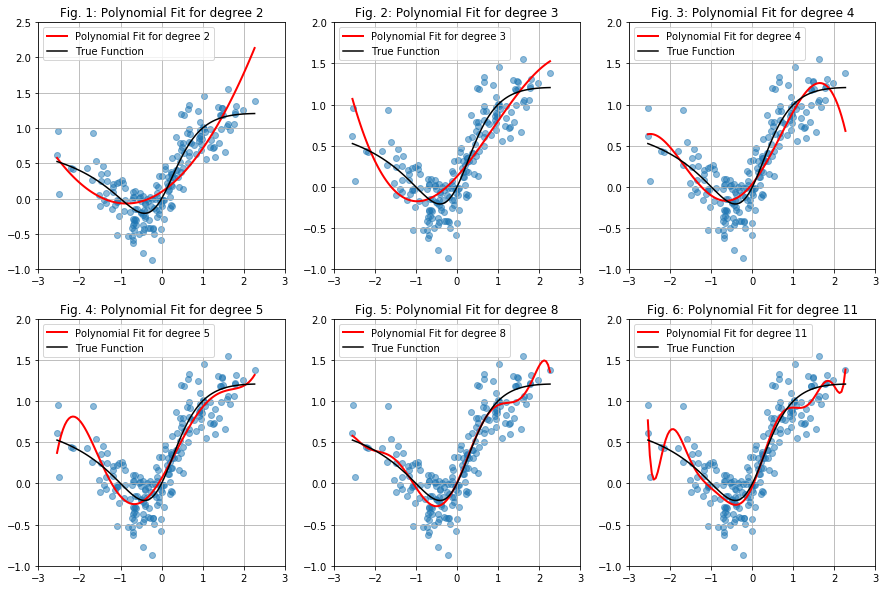

In [8]:
degrees = [2,3,4,5,8,11]
P = []
for i in degrees:
    P.append(np.polyfit(X, Y, deg=i))
fig, axs = plt.subplots(2, 3, figsize=(15,10))
for i in range(6):
    ax = axs.reshape(6,)[i]
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, np.polyval(P[i], x), 'r', lw=2, label='Polynomial Fit for degree ' + str(int(degrees[i])))
    ax.plot(x, g(x), 'k', label='True Function')
    ax.set_title('Fig. '+str(i+1)+': '+'Polynomial Fit for degree ' + str(int(degrees[i])))
    ax.legend(loc=0)

Comment: Obviously, the Polynomial Fit for degree 3 seems be the best fit. When the degree is larger than 3, the polynomial fits will obsolutely overfit. For the Polynomial Fit with degree 2, the fit is a little underfitting but not obvious.

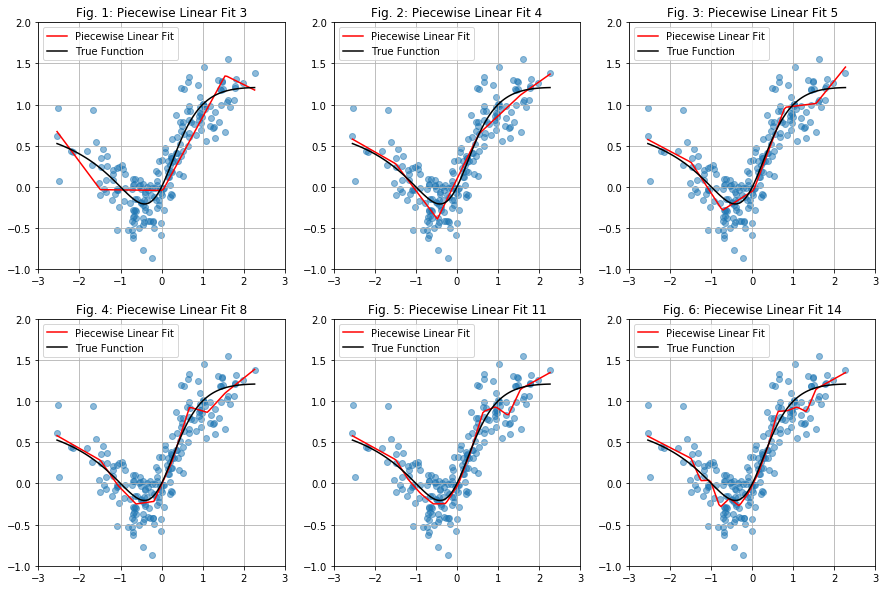

In [9]:
xknots_num = [3,4,5,8,11,14]
fig, axs = plt.subplots(2, 3, figsize=(15,10))
for i in range(6):
    xknots = np.linspace(np.percentile(X, 5), np.percentile(X, 95), xknots_num[i])
    ps, fs = pwlinear_fit(X, Y, xknots)
    ax = axs.reshape(6,)[i]
    ax.scatter(X, Y, alpha=0.5)
    ax.set_title('Fig. '+str(i+1)+': '+'Piecewise Linear Fit ' + str(int(xknots_num[i])))
    ax.plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), 'r', label='Piecewise Linear Fit')
    ax.plot(x, g(x), 'k', label='True Function')
    ax.legend(loc=0)

Comment: Obviously, the Piecewise Linear Fit for degree 5 seems be the best fit. When the degree is larger than 5, the Piecewise Linear Fits will obsolutely overfit. For the Piecewise Linear Fit with degree 3 and 4, the fits were underfitting.

<b>Question 1.2</b>. For nonparametric regression,
<ul>
<li>Try different bandwidth values in the kernel regression. Reproduce
    the scatter plot with fitted regression function. Compare and comment on the results. For what values of the bandwidth do we observe overfitting? For what values of the bandwidth do we observe a poor fit?</li>
<li>Try to use different kernels, for example
$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere.}$$
Which has more impact: the bandwidth $h$ or the kernel $K$?
</ul>

In [10]:
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
inflation = np.array(range(1,7))/3
bandwidth_arr = bw_silverman*inflation

In [11]:
def indicator_fun1(x,a,b):
    if x<=b and x>=a:
        return 1
    else:
        return 0
v_indicator_fun1 = np.vectorize(indicator_fun1)

In [12]:
def quadratic_kern(x):
    """Quadratic kernel function"""
    multipler = 1 - np.power(x,2)
    return multipler*multipler*v_indicator_fun1(multipler,0,1)

def Cauchy_kern(x):
    import math
    """Cauchy kernel function"""
    return 1/(math.pi*(1+np.power(x,2)))

def Trigonometric_kern(x):
    import math
    """Trigonometric kernel function"""
    return 1/(2*math.pi)*(2*np.sin(x/2)/x)*(2*np.sin(x/2)/x)*(1-v_indicator_fun1(x,0,0))+1/(2*math.pi)*v_indicator_fun1(x,0,0)

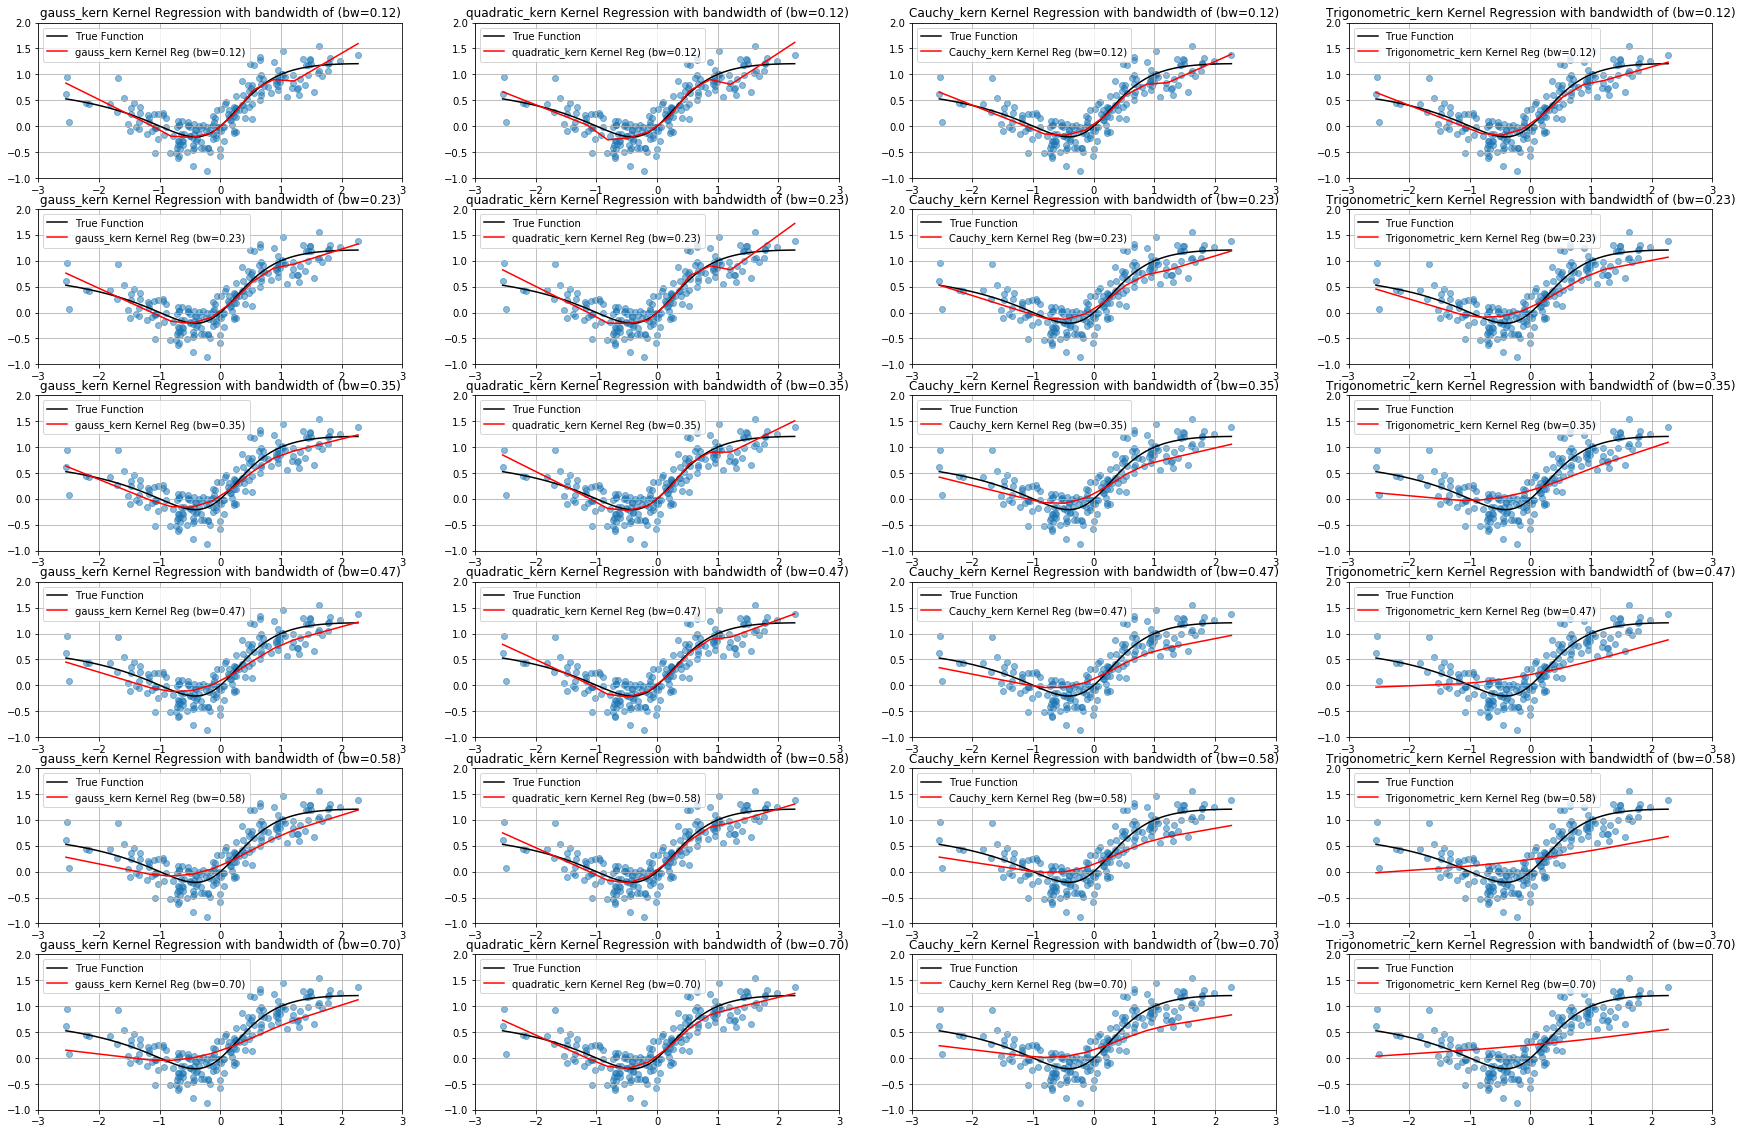

In [13]:
# Kernel Regressions
Kernels = [gauss_kern, quadratic_kern, Cauchy_kern, Trigonometric_kern]
Kernels_name = ['gauss_kern', 'quadratic_kern', 'Cauchy_kern', 'Trigonometric_kern']
import itertools
product = []
product_name = []
for item in itertools.product(bandwidth_arr,Kernels):
    product.append(item)
for item in itertools.product(bandwidth_arr,Kernels_name):
    product_name.append(item)
product = np.array(product)
product_name = np.array(product_name)
fig, axs = plt.subplots(6,4, figsize=(30, 20))
xknots0 = np.linspace(np.percentile(X, 5), np.percentile(X, 95), 10)
for i in range(24):
    ax = axs.reshape(24,)[i]
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    yknots0 = kern_reg(xknots0, X, Y, product[i][0], product[i][1])
    f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
    ax.plot(x, f0(x), color='r', label=product_name[i][1]+' Kernel Reg (bw={:.2f})'.format(product[i][0]))
    ax.set_title(product_name[i][1]+' Kernel Regression with bandwidth of '+ '(bw={:.2f})'.format(product[i][0]))
    ax.legend(loc=0)

#### Ans:
For nonparametric regression,

Try different bandwidth values in the kernel regression. Reproduce
    the scatter plot with fitted regression function. Compare and comment on the results. For what values of the bandwidth do we observe overfitting? For what values of the bandwidth do we observe a poor fit?
    
Ans:

From my obervation, I think there are underfittings when the bandwidth is 0.59, 0.71 and there are overfittings when the bandwidth is 0.12.  


Try to use different kernels, for example
$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere.}$$
Which has more impact: the bandwidth $h$ or the kernel $K$?

Ans:

I think both of them can impact the result in a large extent. 

From my obervation, the same kernel different bandwidths can have very different values and for the same bandwidth different kernels can also be very different. For example, for Trigonometric kernel, using bandwidth of 0.12 seems be a good choice. However, for quadratic kernel, it's a bad choice. So the choice of kernel actually has a lot of impacts.  

Also, for Trigonometric kernel, bandwidth of 0.71 is absolutely underfitting but bandwidth of 0.12 seems to be good. So the choice of bandwidth also has a lot of impacts.  

# 2. American Option Pricing

In [14]:
def blackscholes_mc(ts, n_paths, S0, vol, r, q):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    ts: array_like
        The time steps of the simualtion
    n_paths: int
        the number of paths to simulate
    S0: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    paths = np.full((len(ts), n_paths), np.nan, dtype=np.float)
    paths[0] = S0
    for i in range(len(ts)-1):
        dt = ts[i+1] - ts[i]
        dW = np.sqrt(dt)*np.random.randn(n_paths)
        paths[i+1] = paths[i] * np.exp((r-q-1/2*vol**2)*dt + vol*dW)
    return paths

In [15]:
S0 = 100
vol = 0.2
r = 0.1
q = 0.02
K = 100
T = 1

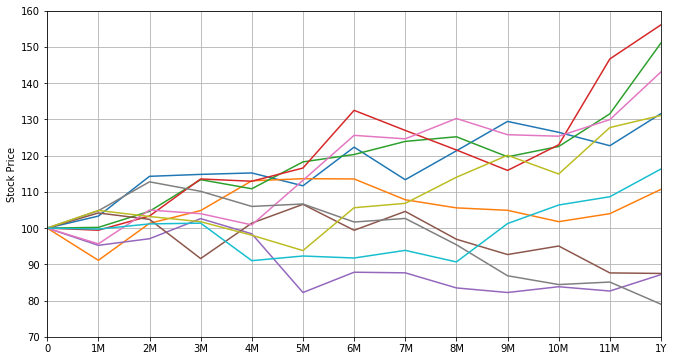

In [16]:
ts = np.linspace(0, 1, 13)
n_paths = 10000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(ts, paths[:, :10])
ax.set_xticks(ts)
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y'])
ax.set_ylabel('Stock Price')
ax.grid(True)

### Price of European put option

In [17]:
np.mean(np.maximum(K-paths[-1], 0))*np.exp(-r*T)

4.246909675059549

### Price of Bermudan put option with monthly exercises

#### Longstaff-Schwartz algorithm

We use polynomials as basis functions for demonstration purposes.

In [18]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    p = np.polyfit(paths[i], payoff, deg=2)
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

4.888620892026914

#### Tsitsiklis-van Roy algorithm

The price from the TVR algorithm is generally too high because regression errors accumulate in the backward induction.

In [19]:
V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    p = np.polyfit(paths[i], V*discount, deg=2)
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)
np.mean(V)*np.exp(-r*(ts[1]-ts[0]))

6.240880395852562

## Questions

<b>Question 2.1</b>. Adapt the Longstaff-Schwartz and TVR code to use different regression methods:

<b>(a).</b> Black-Scholes put prices.
<br>
Use the constant 1.0 and the Black-Scholes price of a European put option with volatility $\bar\sigma = 0.2$ and maturity $T-t$ as the two basis functions at time $t$. For your convenience, the Black-Scholes pricing formula is included in the cell below.

<b>(b).</b> Piecewise Linear regression.

Note: choose the number of knots appropriately in the regression.</li>

<b>(c).</b> Kernel regression with Gaussian kernel.

Note: Choose the bandwidth appropriately.</li>

In [20]:
def blackscholes_price(K, T, S0, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S0: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    from scipy.stats import norm
    F = S0*np.exp((r-q)*T)
    v = vol*np.sqrt(T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

### 2.1.a Longstaff-Schwartz

In [21]:
# 2.1.a Longstaff-Schwartz
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    # reference: piece-wise linear function above
    fs = [lambda x: np.ones_like(x, dtype=np.float), lambda x: blackscholes_price(K, T-ts[i], x, 0.2, r=0, q=0, callput='put')]
    A = np.vstack([f(paths[i]) for f in fs]).T
    ps = np.linalg.lstsq(A, payoff, rcond=None)[0]
    # ============ reference end ============
    contval = np.dot(A,ps.T)
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
print("The price of the Bermudan put option is: ", np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

The price of the Bermudan put option is:  4.9371728328240065


### 2.1.a TVR

In [22]:
# 2.1.a TVR
V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    # reference: piece-wise linear function above
    fs = [lambda x: np.ones_like(x, dtype=np.float), lambda x: blackscholes_price(K, T-ts[i], x, 0.2, r=0, q=0, callput='put')]
    A = np.vstack([f(paths[i]) for f in fs]).T
    ps = np.linalg.lstsq(A, payoff, rcond=None)[0]
    # ============ reference end ============
    contval = np.dot(A,ps.T)
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)
print("The price of the Bermudan put option is: ", np.mean(V)*np.exp(-r*(ts[1]-ts[0])))

The price of the Bermudan put option is:  4.957922792628231


### 2.1.b Piecewise Linear regression.

#### I choose the xknots by cross validation among different xknots numbers which means choosing the xknots = argmin SSE_Out_Of_Sample.

In [23]:
def pwlinear_fit_graph(X,Y,xknots_num = [5,6,7,8,9,10]):
    """Draw the piece-wise linear regression from mutiple xknots 
    
    Parameters
    ----------
    X: the data matrix or the multi-dimension ndarry includes the information of the data to be regressed
    Y: the target vector which is the target to be fitted in the regression
    xknots_num: scalar or array_like, including the candidate of the parameter xknots

    Returns
    -------
    None
    """
    fig, axs = plt.subplots(len(xknots_num),1, figsize=(5,25))
    for i in range(len(xknots_num)):
        xknots = np.linspace(np.percentile(X, 5), np.percentile(X, 95), xknots_num[i])
        ps, fs = pwlinear_fit(X, Y, xknots)
        ax = axs.reshape(len(xknots_num),)[i]
        ax.scatter(X, Y, alpha=0.5)
        ax.set_title('Fig. '+str(i+1)+': '+'Piecewise Linear Fit ' + str(int(xknots_num[i])))
        plt.xlim(min(X), max(X))
        plt.ylim(min(Y), max(Y))
        x = np.linspace(X.min(), X.max(), 101)
        ax.plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), 'r', label='Piecewise Linear Fit')
        ax.legend(loc=0)

In [24]:
def cross_validation(X,Y,xknots_num,test_size=0.20):
    """Find the best xknots by cross validation
    
    Parameters
    ----------
    X: the data matrix or the multi-dimension ndarry includes the information of the data to be regressed
    Y: the target vector which is the target to be fitted in the regression
    xknots_num: scalar or array_like, including the candidate of the parameter xknots
    test_size: int, the propotion of the test set in the whole dataset
    Returns
    -------
    int, the best xknots in the cross validation which gives the least out-of-sample error
    """
    from sklearn.model_selection import train_test_split
    SSE_OOS_xknots = []
    for j in range(len(xknots_num)):
        xknots = np.linspace(np.percentile(X, 5), np.percentile(X, 95), xknots_num[j])
        SSE_OOS_sum = 0
        for i in range(1000):
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=int(np.random.uniform(0,100)))
            ps, fs = pwlinear_fit(X_train, y_train, xknots)
            yhat = lambda x: sum([f(x)*p for (f, p) in zip(fs, ps)])
            SSE_OOS = np.sum(np.power(yhat(X_test) - y_test,2))
            SSE_OOS_sum += SSE_OOS
        SSE_OOS_xknots.append(SSE_OOS)
    return xknots_num[SSE_OOS_xknots.index(min(SSE_OOS_xknots))]

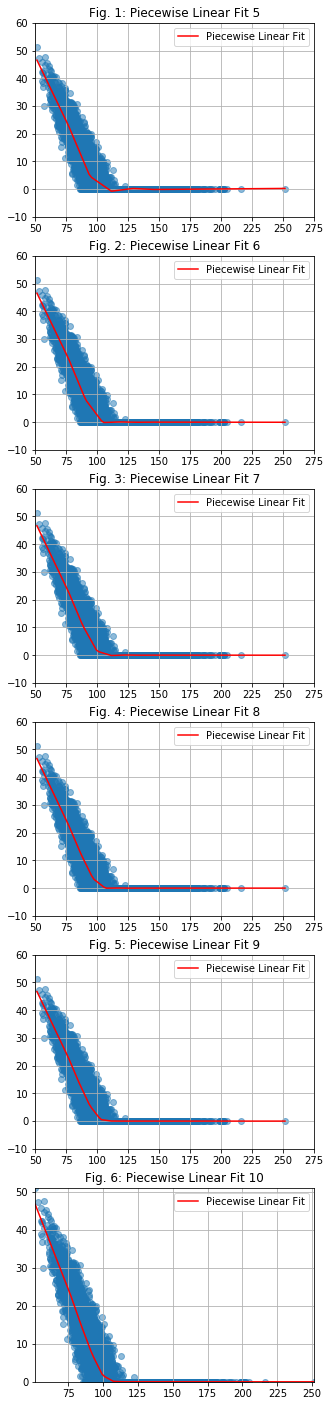

In [25]:
S0 = 100
vol = 0.2
r = 0.1
q = 0.02
K = 100
T = 1
ts = np.linspace(0, 1, 13)
n_paths = 10000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
payoff = np.maximum(K-paths[-1], 0)
pwlinear_fit_graph(paths[-2],np.maximum(K-paths[-1], 0),xknots_num = [5,6,7,8,9,10])

In [40]:
result = []
for i in range(10): # 10 is the test times of the cross validation
    result.append(cross_validation(paths[-2],np.maximum(K-paths[-1], 0),xknots_num = [5,6,7,8,9,10]))
from collections import Counter
Counter(result)

Counter({9: 3, 5: 1, 7: 4, 6: 1, 8: 1})

From the graph, I cannot recognize which is better. So I choose to do cross validation can compare the out-of-sample error. (i.e. choosing the xknot s.t. the out-of-sample error is mininal.)  
After 100 times of cross_validation, we find the best quantity of xknots fluctuate between 7 and 10.

We decided to take 7 as the quantity of xknots.

#### 2.1.b Piecewise Linear regression -  Longstaff-Schwartz

In [27]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    xknots = np.linspace(np.percentile(paths[i], 5), np.percentile(paths[i], 95), 7)
    ps, fs = pwlinear_fit(paths[i], payoff, xknots)
    A = np.vstack([f(paths[i]) for f in fs]).T
    contval = np.dot(A,ps.T)
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
print("The price of the Bermudan put option is: ", np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

The price of the Bermudan put option is:  5.199229825476071


#### 2.1.b Piecewise Linear regression - TVR

In [28]:
V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    xknots = np.linspace(np.percentile(X, 5), np.percentile(X, 95), 7)
    ps, fs = pwlinear_fit(paths[i], payoff, xknots)
    A = np.vstack([f(paths[i]) for f in fs]).T
    contval = np.dot(A,ps.T)
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)
print("The price of the Bermudan put option is: ", np.mean(V)*np.exp(-r*(ts[1]-ts[0])))

The price of the Bermudan put option is:  5.265466700493269


### 2.1.c Kernel regression with Gaussian kernel.

#### 2.1.c Kernel regression with Gaussian kernel - Longstaff-Schwartz

#### I choose the bandwidth: $$(\frac{4\sigma^5}{3n})^{0.2}$$
which is a therotical optimization bandwidth for Gaussian Kernel

In [29]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    bw_silverman = (4/(3*len(paths[i])))**0.2*np.std(paths[i])
    xknots0 = np.linspace(np.percentile(paths[i], 5), np.percentile(paths[i], 95), 7)
    yknots0 = kern_reg(xknots0, paths[i], payoff, bw_silverman, gauss_kern)
    contval = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')(paths[i])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
print("The price of the Bermudan put option is: ", np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

The price of the Bermudan put option is:  5.171824226096742


#### 2.1.c Kernel regression with Gaussian kernel - TVR

In [30]:
V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    bw_silverman = (4/(3*len(paths[i])))**0.2*np.std(paths[i])
    xknots0 = np.linspace(np.percentile(paths[i], 5), np.percentile(paths[i], 95), 7)
    yknots0 = kern_reg(xknots0, paths[i], payoff, bw_silverman, gauss_kern)
    contval = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')(paths[i])
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)
print("The price of the Bermudan put option is: ", np.mean(V)*np.exp(-r*(ts[1]-ts[0])))

The price of the Bermudan put option is:  5.173371996284825


<b>Question 2.2</b>. Both TVR and Longstaff-Schwartz algorithms provide an estimate for the expected payoff from continuation at each exercise date from the cross-sectional information in the simulation using regression. By comparing this estimate with the immediate exercise value, the holder of the option can determine whether to exercise the option or continue. 

Perform an independent Monte Carlo simulation using this estimate of continuation value from <b>both</b> algorithms as an exercise policy, and estimate the price of the American put. Explain why this estimate is a lower bound. The basis functions for regression can be chosen to be the quadratic polynomial as in the sample code.

Show your code and result with at least 100000 simulations.

### 2.2 independent Monte Carlo simulation - Longstaff-Schwartz

In [31]:
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
payoff = np.maximum(K-paths[-1], 0)
P_arr=[]
# Backward
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    p = np.polyfit(paths[i], payoff, deg=2)
    P_arr.append(p[:])
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
    
# Forward
P_arr.reverse()
V = 0
N = 100000

previously_ex = np.array([False]*N)
Independent_MC_paths = blackscholes_mc(ts, N, S0, vol, r, q)
MC_payoff = np.maximum(K-Independent_MC_paths[0], 0)

for i in range(1, len(ts)-1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    MC_payoff = MC_payoff*discount
    contval = np.polyval(P_arr[i-1], Independent_MC_paths[i])
    exerval = np.maximum(K-Independent_MC_paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    MC_payoff[ind] = exerval[ind]
    V += np.sum(MC_payoff[~previously_ex*ind])
    previously_ex += ind
V = V + np.sum(np.maximum(K-Independent_MC_paths[len(ts)-1][~previously_ex], 0))*np.exp(-r*(ts[-1]-ts[-2]))
print("The price of the Bermudan put option is: ", V/N)

The price of the Bermudan put option is:  5.185155025945513


### 2.2 independent Monte Carlo simulation - TVR

In [32]:
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
payoff = np.maximum(K-paths[-1], 0)
P_arr=[]
# Backward
V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    p = np.polyfit(paths[i], V*discount, deg=2)
    P_arr.append(p[:])
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)

# Forward
P_arr.reverse()
V = 0
N = 100000

previously_ex = np.array([False]*N)
Independent_MC_paths = blackscholes_mc(ts, N, S0, vol, r, q)
MC_payoff = np.maximum(K-Independent_MC_paths[0], 0)

for i in range(1, len(ts)-1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    MC_payoff = MC_payoff*discount
    contval = np.polyval(P_arr[i-1], Independent_MC_paths[i])
    exerval = np.maximum(K-Independent_MC_paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    MC_payoff[ind] = exerval[ind]
    V += np.sum(MC_payoff[~previously_ex*ind])
    previously_ex += ind
V = V + np.sum(np.maximum(K-Independent_MC_paths[len(ts)-1][~previously_ex], 0))*np.exp(-r*(ts[-1]-ts[-2]))
print("The price of the Bermudan put option is: ", V/N)

The price of the Bermudan put option is:  5.315114024931827


Explain why this estimate is a lower bound.  
Ans: The estimation is a lower bound because the definition of the real American option price is:$$\sup_{\tau\in \tau_{t,T}} E^{Q}[D_{t,\tau}F_{\tau}|F_{t}]$$
which means maxing over all possible optimal stopping time.

This estimation can be considered as a sample of these stopping time. Thus, this estimation is always lower than the real price.


<b>Question 2.3</b> Oftentimes parametric regressions may not produce globally accurate estimates of continuation values for all possible values of state variables. One approach to improve the accuracy is to run regression only in the region where option is in the money. When the option is out of money, one should always choose to continue, therefore there is no need to estimate the continuation value.

Modify the Longstaff-Schwartz code to implement this improvement.

Show your code and results with the following basis functions:

<b>(a).</b> quadratic polynomial basis functions;

<b>(b).</b> basis functions given in Question 2.1(a)

For each case, identify and plot the exercise and continuation regions at time $t=0.5$. Comment on the result.

In [33]:
# 2.3.a polynomials-Longstaff-Schwartz algorithm
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    exerval = np.maximum(K-paths[i], 0)
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    ITM = np.where(exerval > 0)
    p = np.polyfit(paths[i][ITM], payoff[ITM], deg=2)
    contval = np.zeros(n_paths)
    contval[ITM] = np.polyval(p, paths[i][ITM])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
    if ts[i] == 0.5:
        path5 = paths[i]
        contval5 = contval
        exerval5 = exerval
print("The price of the Bermudan put option is: ", np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

The price of the Bermudan put option is:  5.155620874719849


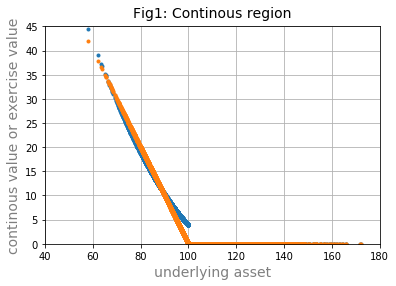

In [34]:
plt.title('Fig1: Continous region',fontsize=14,verticalalignment='bottom')
plt.plot(path5, contval5,'.')
plt.plot(path5, exerval5,'.')
plt.ylabel('continous value or exercise value',fontsize=14,alpha=0.5)
plt.xlabel('underlying asset',fontsize=14,alpha=0.5)
plt.show()

The region that the blue line is above the orange line is the continuation region. Else, it's the exercise region.

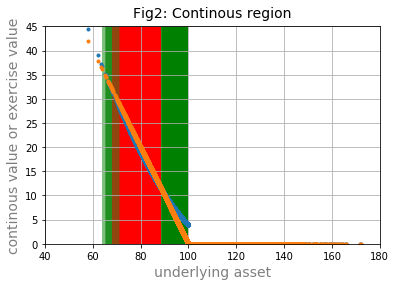

In [35]:
fig, ax = plt.subplots()
plt.title('Fig2: Continous region',fontsize=14,verticalalignment='bottom')
ax.plot(path5, contval5,'.')
ax.plot(path5, exerval5,'.')
plt.ylabel('continous value or exercise value',fontsize=14,alpha=0.5)
plt.xlabel('underlying asset',fontsize=14,alpha=0.5)
# use data coordinates for the x-axis and the axes coordinates for the y-axis
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.fill_between(path5, 0, 45, where=contval5 > exerval5,
                facecolor='green', alpha=0.5, transform=trans)
ax.fill_between(path5, 0, 45, where=contval5 < exerval5,
                facecolor='red', alpha=0.5, transform=trans)
plt.show()


In [36]:
# 2.3.a basis functions given in Question 2.1-Longstaff-Schwartz algorithm
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    ITM = np.where(exerval > 0)
    # reference: piece-wise linear function above
    fs = [lambda x: np.ones_like(x, dtype=np.float), lambda x: blackscholes_price(K, T-ts[i], x, 0.2, r=0, q=0, callput='put')]
    A = np.vstack([f(paths[i][ITM]) for f in fs]).T
    ps = np.linalg.lstsq(A, payoff[ITM], rcond=None)[0]
    #print(ps.shape)
    # ============ reference end ============
    contval = np.zeros(n_paths)
    contval[ITM] = np.dot(A,ps.T)
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
    if ts[i] == 0.5:
        path5 = paths[i]
        contval5 = contval
        exerval5 = exerval
print("The price of the Bermudan put option is: ", np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

The price of the Bermudan put option is:  5.0087836044586735


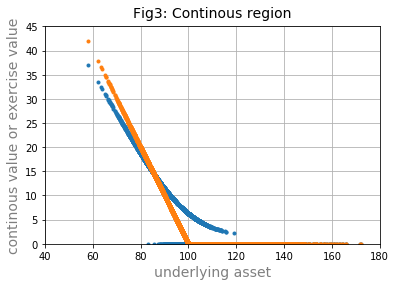

In [37]:
plt.title('Fig3: Continous region',fontsize=14,verticalalignment='bottom')
plt.plot(path5, contval5,'.')
plt.plot(path5, exerval5,'.')
plt.ylabel('continous value or exercise value',fontsize=14,alpha=0.5)
plt.xlabel('underlying asset',fontsize=14,alpha=0.5)
plt.show()

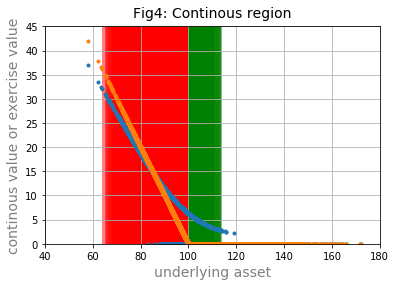

In [38]:
fig, ax = plt.subplots()
plt.title('Fig4: Continous region',fontsize=14,verticalalignment='bottom')
plt.ylabel('continous value or exercise value',fontsize=14,alpha=0.5)
plt.xlabel('underlying asset',fontsize=14,alpha=0.5)
ax.plot(path5, contval5,'.')
ax.plot(path5, exerval5,'.')
# use data coordinates for the x-axis and the axes coordinates for the y-axis
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.fill_between(path5, 0, 45, where=contval5 > exerval5,
                facecolor='green', alpha=0.5, transform=trans)
ax.fill_between(path5, 0, 45, where=contval5 < exerval5,
                facecolor='red', alpha=0.5, transform=trans)
plt.show()

The region that the blue line is above the orange line is the continuation region. Else, it's the exercise region.

Comment:  
The regression with the polynomials basis function has a better effect than the regression with the basis functions given in Question 2.1. From the graph Fig4, we can see there is a strange patern on the continuous value around 100. The regressor is not behaving good here. Therefore, I think the polynomial regression is better.

<b>Question 2.4</b>. Use the Longstaff-Schwartz algorithm to price an Bermudan-Asian call option. The underlying security price is assumed to follow the geometric Brownian motion

$$\frac{dS_t}{S_t}=(r-q)dt+\sigma dW_t$$

with $S_0=100$, $r=0$, $q=0$ and $\sigma=0.2$. The option has a strike of $K=100$ and a final expiration date of $T=1$ and can be exercised every month before the final maturity, i.e.
$$t_1=\frac{1}{12},\, t_2=\frac{2}{12},\, \ldots,\, t_{12}=1$$

The cashflow from exercising the option at time $t_n$, $n=1,\ldots,12$, is $\max\left(0, A_{t_n}-K\right)$ with $A_{t_n}=\frac{1}{n}\sum_{i=1}^nS_{t_i}$.

As the basis functions in the regression at time $t_n$, use the constant 1.0 and the Black-Scholes value of a European call option with strike $K$, maturity $T-t_n$, and volatility $\bar\sigma = 0.1$, written on
$$
Z_{t_n}\equiv \frac{nA_{t_n}+(12-n)S_{t_n}}{12}
$$

As in Question 2.4, after you have obtained estimations of continuation values from the Longstaff-Schwartz algorithm, run an independent Monte Carlo simulation with at least 100000 paths to obtain a low-biased price. Explain the use of $Z_{t_n}$ instead of simply $A_{t_n}$ or $S_{t_n}$.

In [39]:
ts = np.linspace(0, 1, 13)
S0 = 100
r = 0
q = 0
vol = 0.2
K = 100
T = 1
n_paths = 10000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
A = np.array([np.mean(paths[:i],axis = 0) for i in range(13)])
Z = np.array([(i*A[i]+(12-i)*paths[i])/12 for i in range(13)])
payoff = np.maximum(A[-1]-K, 0)
P_arr = []
# Backward
for i in range(len(ts)-2, 0, -1):
    exerval = np.maximum(A[i]-K, 0)
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    ITM = np.where(exerval > 0)
    fs = [lambda x: np.ones_like(x, dtype=np.float), lambda x: blackscholes_price(K, T-ts[i], x, 0.1, r=0, q=0, callput='call')]
    B = np.vstack([f(Z[i][ITM]) for f in fs]).T
    ps = np.linalg.lstsq(B, payoff[ITM], rcond=None)[0]
    P_arr.append(ps)
    contval = np.zeros(n_paths)
    contval[ITM] = np.dot(B,ps.T)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
    
# Forward
P_arr.reverse()
V = 0
N = 100000

previously_ex = np.array([False]*N)
Independent_MC_paths = blackscholes_mc(ts, N, S0, vol, r, q)

A = np.array([np.mean(Independent_MC_paths[:i],axis = 0) for i in range(13)])
Z = np.array([(i*A[i]+(12-i)*Independent_MC_paths[i])/12 for i in range(13)])
Asian_tmp = []
MC_payoff = np.maximum(Independent_MC_paths[0] - K, 0)

for i in range(1, len(ts)-1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    MC_payoff = MC_payoff*discount
    
    fs = [lambda x: np.ones_like(x, dtype=np.float), lambda x: blackscholes_price(K, T-ts[i], x, 0.1, r=0, q=0, callput='call')]
    B = np.vstack([f(Z[i]) for f in fs]).T

    contval = np.dot(B,P_arr[i-1].T)

    exerval = np.maximum(A[i]-K, 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    MC_payoff[ind] = exerval[ind]
    V += np.sum(MC_payoff[~previously_ex*ind])
    previously_ex += ind
V = V + np.sum(np.maximum(A[len(ts)-1][~previously_ex]-K, 0))*np.exp(-r*(ts[-1]-ts[-2]))
print("The price of the Bermudan-Asian call option is: ", V/N)

c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The price of the Bermudan-Asian call option is:  4.88302703015551


Explain the use of $Z_{t_n}$ instead of simply $A_{t_n}$ or $S_{t_n}$.

Ans: Because, at time $t_n\in(0,T)$, we don't know anything about the furture (t_n,T], we should not use something like $S_{t_i}$ where $t_i\in(t_n,T]$. Thus, we use $S_{t_n}$ instead of $S_{t_i}$ during calculation.
$$
Z_{t_n}\equiv \frac{nA_{t_n}+(12-n)S_{t_n}}{12}
$$

The $nA_{t_n}$ is the historical part and the $(12-n)S_{t_n}$ is the approach that we avoid using furture information.